# Qiskit for qudits introduction

To setup, install the package using "pip -e ."". The html documentation is already included in "qiskit_qudits/docs/_build/html", so you do not need to install the requirements for the sphinx documentation tool.

The main addition to qiskit is the class QuditCircuit. Alongside we created Qudit objects and the associated QuditRegister. We also created the new classes Quditinstruction and Quditgate, which can accept Qudit arguments.

## QuditRegister
Since qudits can have dimensions different from 2 (qubits). The most important qudit representation is a list of qudit dimensions. It is analogue to the number of qubits / classical bits.
A QuditRegister is created using these qudit dimensions.

In [1]:
from qiskit_qudits import QuditRegister

qd = QuditRegister([2, 9, 3], name='qd')
qd

QuditRegister(3, 'qd')

QuditRegisters are instances of QuantumRegisters. This is archieved by passing the number of needed Qubits to the superclass. QuditRegisters also hold a seperate list of Qudit objects, which themself hold references to their underlying Qubits. Qudits can be accessed via imaginary indices.

In [2]:
from qiskit import QuantumRegister

print(isinstance(qd, QuantumRegister))

print(type(qd[1]), type(qd[0j]), type(qd[0j][0]))
qd[1j:]

True
<class 'qiskit.circuit.quantumregister.Qubit'> <class 'qiskit_qudits.circuit.quditregister.Qudit'> <class 'qiskit.circuit.quantumregister.Qubit'>


[Qudit(QuditRegister(3, 'qd'), 1), Qudit(QuditRegister(3, 'qd'), 2)]

As a general rule, qudit methods or attributes either start with 'qd_' or can be accessed via imaginary indices. Qudits also hold attributes such as their dimension, or the number of underlying qubits.

In [3]:
for qudit in qd.qd_iter():
    print(qudit.dimension, qudit.size)

2 1
9 4
3 2


## QuditCircuit

A QuditCircuit is analog to a QuantumCircuit, like QuditRegister is to QuantumRegister. It can add qudits via a QuditRegister, a list of qudit dimensions or a list of Qudit instances. Each QuditRegister is also added as a QuantumRegister. \
The for non registers/bits the possibilities are: \
int -> QuantumRegister \
int, int -> QuantumRegister, ClassicalRegister \
list(int) -> QuditRegister \
list(int), int -> QuditRegister, ClassicalRegister \
list(int), int, int -> QuditRegister, QuantumRegister, ClassicalRegister \
We also allow 0 and [] as arguments for the sake of convenience, resulting in no Register created.

In [4]:
from qiskit_qudits import QuditCircuit

qdc0 = QuditCircuit(qd)
print(qdc0.qdregs, qdc0.qregs)
print(qdc0.qudits)
print(qdc0.qubits)
print(qdc0.clbits)

[QuditRegister(3, 'qd')] [QuditRegister(3, 'qd')]
[Qudit(QuditRegister(3, 'qd'), 0), Qudit(QuditRegister(3, 'qd'), 1), Qudit(QuditRegister(3, 'qd'), 2)]
[Qubit(QuditRegister(7, 'qd'), 0), Qubit(QuditRegister(7, 'qd'), 1), Qubit(QuditRegister(7, 'qd'), 2), Qubit(QuditRegister(7, 'qd'), 3), Qubit(QuditRegister(7, 'qd'), 4), Qubit(QuditRegister(7, 'qd'), 5), Qubit(QuditRegister(7, 'qd'), 6)]
[]


Qudits are ordered above qubits (which in turn are above classical bits) and should be thought of as isolated entities. Currently there is not support for qudit circuit drawings. For accessing qubit gates and instructions, the qubit indices are shifted.

In [5]:
qdc = QuditCircuit([5,4], 2, 3)
qdc.zd(0)
qdc.cx(1, 0)
print(qdc)

      ┌─────┐
qd_0: ┤0    ├
      │     │
qd_1: ┤1 ZD ├
      │     │
qd_2: ┤2    ├
      └─────┘
qd_3: ───────
             
qd_4: ───────
       ┌───┐ 
 q_0: ─┤ X ├─
       └─┬─┘ 
 q_1: ───■───
             
 c: 3/═══════
             


c:\users\tim\documents\- dokumente\code\qudits hackathon 2021\qiskit_qudits\circuit\quditcircuit.py:913: UserWarning: Qudit circuit drawer not implemented yet
  warnings.warn("Qudit circuit drawer not implemented yet")


To accomadate qudits, the functions measure(), reset() and delay() now use the same arguement scheme as all other qudit instructions: Qudit arguments first, then qubits, then classical bits. 

In [6]:
qdc.measure(qdargs=1, qargs=1, cargs=qdc.clbits)
print(qdc)

      ┌─────┐               
qd_0: ┤0    ├───────────────
      │     │               
qd_1: ┤1 ZD ├───────────────
      │     │               
qd_2: ┤2    ├───────────────
      └─────┘┌──────────┐   
qd_3: ───────┤0         ├───
             │          │   
qd_4: ───────┤1         ├───
       ┌───┐ │          │   
 q_0: ─┤ X ├─┤          ├───
       └─┬─┘ │  MEASURE │┌─┐
 q_1: ───■───┤          ├┤M├
             │          │└╥┘
 c_0: ═══════╡0         ╞═╬═
             │          │ ║ 
 c_1: ═══════╡1         ╞═╬═
             └──────────┘ ║ 
 c_2: ════════════════════╩═
                            


C:\Users\Tim\miniconda3\envs\qiskit\lib\site-packages\qiskit\visualization\text.py:584: RuntimeWarning: The parameter "cregbundle" was disable, since an instruction needs to refer to individual classical wires
  return "\n".join(self.lines()).encode(self.encoding).decode(self.encoding)


Accessing single qubits of qudits results in an error. There is a boolean parameter "modular_qudits" we can give QuditCircuit upon creation to allow the access, but since qudits and their underlying 
qubits should be thought of as a single entity the parameter is false by default.

In [7]:
from qiskit.circuit.exceptions import CircuitError

try:
    qdc.x(qdc.qubits[0])
except CircuitError as e:
    print(e)

'Given qubits contain incomplete part of a qudit.'


### QuditCircuitData
The backend data of QuditCircuits is also accessable via imaginary indices. In turn we see the the qudit context of all insructions. In the non-qudit form, rules (data elements) have their qudit arguements
added as the underlying qubits in the qubit arguments.

In [8]:
print(qdc[0j])
print(qdc[0])

(<qiskit_qudits.circuit.gates.zd.ZDGate object at 0x00000197B707AA30>, [Qudit(QuditRegister(2, 'qd'), 0)], [], [])
(<qiskit_qudits.circuit.gates.zd.ZDGate object at 0x00000197B707AA30>, [Qubit(QuditRegister(5, 'qd'), 0), Qubit(QuditRegister(5, 'qd'), 1), Qubit(QuditRegister(5, 'qd'), 2)], [])


In [9]:
qdc.data[-1] = qdc.data[0]
print(qdc)

<qiskit_qudits.circuit.gates.zd.ZDGate object at 0x00000197B707AA30> [Qubit(QuditRegister(5, 'qd'), 0), Qubit(QuditRegister(5, 'qd'), 1), Qubit(QuditRegister(5, 'qd'), 2)] []
      ┌─────┐  ┌─────┐   
qd_0: ┤0    ├──┤0    ├───
      │     │  │     │   
qd_1: ┤1 ZD ├──┤1 ZD ├───
      │     │  │     │   
qd_2: ┤2    ├──┤2    ├───
      └─────┘┌─┴─────┴──┐
qd_3: ───────┤0         ├
             │          │
qd_4: ───────┤1         ├
       ┌───┐ │          │
 q_0: ─┤ X ├─┤          ├
       └─┬─┘ │  MEASURE │
 q_1: ───■───┤          ├
             │          │
 c_0: ═══════╡0         ╞
             │          │
 c_1: ═══════╡1         ╞
             └──────────┘
 c_2: ═══════════════════
                         


Internally there also exist two methods for appendending gates / instructions. The regular append() and qd_append() which takes qudit arguements and qubit arguements seperatly.

### Circuit methods

Nearly all QuantumCircuit methods exist for QuditCircuits as well (one notable exception being decompose and dag-methods).

In [10]:
qdc1 = QuditCircuit([5, 3, 2], 2, 0, name='circ1')
qdc1.zd(0)
qdc1.x(0)
qdc1.cy(1,0)
qdc1.measure_active()
print("circ1 ----------------------------------------")
print(qdc1)

qdc2 = QuditCircuit([2, 3], 1, 1, name='circ2')
qdc2.zd([0,1])
qdc2.y(0)
qdc2.measure(qargs=0, cargs=0)
print("circ2 ----------------------------------------")
print(qdc2)

qdc3 = qdc1.compose(qdc2, [2, 1], [1], front=True)
print("composition ----------------------------------")
print(qdc3)

qdc4 = qdc1.tensor(qdc2)
print("tensor ---------------------------------------")
print(qdc4)

circ1 ----------------------------------------
           ┌─────┐┌──────────┐   ┌──────────┐      
     qd_0: ┤0    ├┤0         ├───┤0         ├──────
           │     ││          │   │          │      
     qd_1: ┤1 ZD ├┤1 BARRIER ├───┤1         ├──────
           │     ││          │   │          │      
     qd_2: ┤2    ├┤2         ├───┤2         ├──────
           └─────┘└──────────┘   │          │      
     qd_3: ──────────────────────┤          ├──────
                                 │          │      
     qd_4: ──────────────────────┤          ├──────
                                 │          │      
     qd_5: ──────────────────────┤  MEASURE ├──────
            ┌───┐    ┌───┐     ░ │          │┌─┐   
      q_0: ─┤ X ├────┤ Y ├─────░─┤          ├┤M├───
            └───┘    └─┬─┘     ░ │          │└╥┘┌─┐
      q_1: ────────────■───────░─┤          ├─╫─┤M├
                               ░ │          │ ║ └╥┘
measure_0: ══════════════════════╡0         ╞═╬══╬═
                 

### New gates
There are several new gates (and their adjoints), which can only be used on qudits. The generalization of the X gate is currently implemented as a concatination of QFT and the generalized Z gate. And takes an parameter describing the level difference.

In [11]:
qdc = QuditCircuit([8], 1, 0)
qdc.xd(0, 2)
qdc.h(0)
qdc.measure_all()
print(qdc)

        ┌──────┐┌─────┐┌─────┐┌─────────┐┌──────────┐┌──────────┐
  qd_0: ┤0     ├┤0    ├┤0    ├┤0        ├┤0         ├┤0         ├
        │      ││     ││     ││         ││          ││          │
  qd_1: ┤1 QFT ├┤1 ZD ├┤1 ZD ├┤1 QFT_DG ├┤1 BARRIER ├┤1         ├
        │      ││     ││     ││         ││          ││          │
  qd_2: ┤2     ├┤2    ├┤2    ├┤2        ├┤2         ├┤2         ├
        └┬───┬─┘└──░──┘└─┬─┬─┘└─────────┘└──────────┘│          │
   q_0: ─┤ H ├─────░─────┤M├─────────────────────────┤  MEASURE ├
         └───┘     ░     └╥┘                         │          │
meas_0: ══════════════════╬══════════════════════════╡0         ╞
                          ║                          │          │
meas_1: ══════════════════╬══════════════════════════╡1         ╞
                          ║                          │          │
meas_2: ══════════════════╬══════════════════════════╡2         ╞
                          ║                          └──────────┘
meas_3: ══

Some convenience methods were added, like conversion tools or a method to reinterpret the counts dictionary of the Aer simulator with decimal numbers for higher levels. The padding character can be choosen.

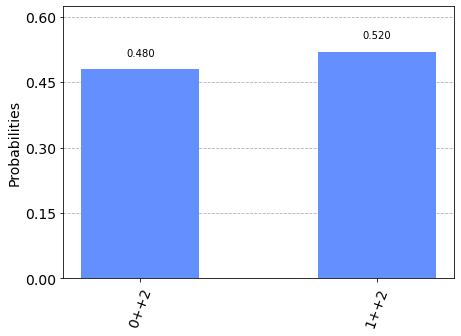

In [12]:
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
from qiskit_qudits.visualization import counts_to_quditcounts

simulator = Aer.get_backend('qasm_simulator')
job = execute(qdc, simulator, shots=100)
counts = job.result().get_counts()
qd_counts = counts_to_quditcounts(qdc, counts, '+')
plot_histogram(qd_counts)

Here we have a level switch gates, which uses an auxiliary qubit to exchange to levels.

        ┌──────────┐┌──────────┐┌──────────┐┌──────────┐   
  qd_0: ┤0         ├┤0         ├┤0         ├┤0         ├───
        │          ││          ││          ││          │   
  qd_1: ┤1         ├┤1         ├┤1 BARRIER ├┤1         ├───
        │  LS(0,2) ││  LS(2,6) ││          ││          │   
  qd_2: ┤2         ├┤2         ├┤2         ├┤2         ├───
        │          ││          │└────░─────┘│          │┌─┐
   q_0: ┤3         ├┤3         ├─────░──────┤  MEASURE ├┤M├
        └──────────┘└──────────┘     ░      │          │└╥┘
meas_0: ════════════════════════════════════╡0         ╞═╬═
                                            │          │ ║ 
meas_1: ════════════════════════════════════╡1         ╞═╬═
                                            │          │ ║ 
meas_2: ════════════════════════════════════╡2         ╞═╬═
                                            └──────────┘ ║ 
meas_3: ═════════════════════════════════════════════════╩═
                                        

c:\users\tim\documents\- dokumente\code\qudits hackathon 2021\qiskit_qudits\circuit\quditcircuit.py:913: UserWarning: Qudit circuit drawer not implemented yet
  warnings.warn("Qudit circuit drawer not implemented yet")
C:\Users\Tim\miniconda3\envs\qiskit\lib\site-packages\qiskit\visualization\text.py:584: RuntimeWarning: The parameter "cregbundle" was disable, since an instruction needs to refer to individual classical wires
  return "\n".join(self.lines()).encode(self.encoding).decode(self.encoding)


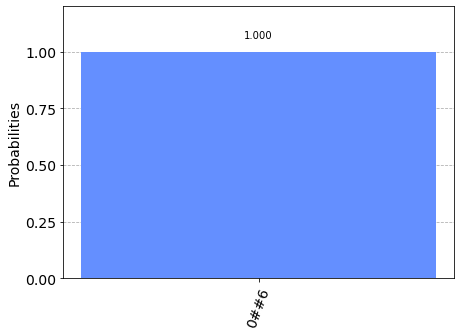

In [13]:
qdc = QuditCircuit([7], 1, 0)
qdc.ls(0, 0, 0, 2)
qdc.ls(0, 0, 2, 6)
qdc.measure_all()
print(qdc)

simulator = Aer.get_backend('qasm_simulator')
job = execute(qdc, simulator, shots=99)
counts = job.result().get_counts()
qd_counts = counts_to_quditcounts(qdc, counts)
plot_histogram(qd_counts)

This gate adds a phase to a single level.

In [14]:
import numpy as np
np.set_printoptions(linewidth=200, precision=2, suppress=True)

qdc = QuditCircuit([7], 1, 0)
qdc.sp(0, 0, 2, np.pi/4)
print(qdc)

backend = Aer.get_backend('unitary_simulator')

job = execute(qdc, backend)
result = job.result()
U = result.get_unitary(qdc)

N = int(U.shape[0]/2)
print("Auxiliary qubit should start and end in state |0> (only look at top left of matrix)")
print(U[:N,:N])


      ┌────────────┐
qd_0: ┤0           ├
      │            │
qd_1: ┤1           ├
      │  SP(2,π/4) │
qd_2: ┤2           ├
      │            │
 q_0: ┤3           ├
      └────────────┘
Auxiliary qubit should start and end in state |0> (only look at top left of matrix)
[[1.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j  ]
 [0.  +0.j   1.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.  +0.j   0.71+0.71j 0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.  +0.j   0.  +0.j   1.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   1.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   1.  +0.j   0.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   1.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   0.  +0.j   1.  +0.j  ]

## More features can be found in the qiskit_qudits/test folder and in the documentation.